Guardar archivos en drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Cambia el nombre si quieres otra carpeta
drive_folder = '/content/drive/MyDrive/Delfin'

# Crear la carpeta si no existe
os.makedirs(drive_folder, exist_ok=True)


Configuración del entorno

In [ ]:
!apt-get update && apt-get install -y sox libsox-dev libsox-fmt-all

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,266 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,103 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/

In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542097 sha256=68db90fb209de960dcc9990131d7df40fe7885f01dcd81e84855fb30a51e750b
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [ ]:
!pip install dtw-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.7/801.7 kB 32.9 MB/s eta 0:00:00


Instalación de dependencias

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from IPython.display import display, HTML
from google.colab import output
import base64
import os


Preprocesamiento

In [ ]:
# Parámetros
TARGET_WORDS = ["house", "right", "down", "go"]
word_to_idx = {w: i for i, w in enumerate(TARGET_WORDS)}
idx_to_word = {i: w for w, i in word_to_idx.items()}
MAX_LEN = 64  # Longitud en frames del espectrograma

# Transformación a espectrograma Mel
mel_spec_transform = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=2048, # Increased FFT size for better frequency resolution
    hop_length=256, # Decreased hop length for better time resolution
    n_mels=128 # Increased number of Mel bins for more frequency detail
)

# Preprocesamiento mejorado con recorte de silencio y ajuste de duración
def preprocess(waveform, sr, trim=True, max_dur=1.0):
    # Resamplear si es necesario
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)

    # Recortar silencios al inicio y final
    if trim:
        waveform, _ = torchaudio.sox_effects.apply_effects_tensor(
            waveform, 16000,
            effects=[
                ["silence", "1", "0.1", "1%"],
                ["reverse"],
                ["silence", "1", "0.1", "1%"],
                ["reverse"]
            ]
        )

    # Normalizar a duración fija (1 segundo)
    target_len = int(16000 * max_dur)
    current_len = waveform.shape[1]
    if current_len > target_len:
        waveform = waveform[:, :target_len]
    elif current_len < target_len:
        pad_len = target_len - current_len
        waveform = torch.nn.functional.pad(waveform, (0, pad_len)) # Corrected padding

    # Convertir a espectrograma Mel y escalar a dB
    mel_spec = mel_spec_transform(waveform).squeeze(0)
    mel_spec_db = T.AmplitudeToDB()(mel_spec)

    # Ajustar a longitud fija en el eje tiempo
    # We need to recalculate MAX_LEN based on the new hop_length and target_len
    new_max_len = int(np.ceil(target_len / mel_spec_transform.hop_length))
    if mel_spec_db.shape[1] < new_max_len:
        mel_spec_db = torch.nn.functional.pad(mel_spec_db, (0, new_max_len - mel_spec_db.shape[1])) # Corrected padding
    else:
        mel_spec_db = mel_spec_db[:, :new_max_len]

    return mel_spec_db

Filtrado de dataset

In [ ]:
class FilteredSpeechCommands(Dataset):
    def __init__(self, dataset):
        self.data = []
        for waveform, sr, label, *_ in dataset:
            if label in TARGET_WORDS:
                spec = preprocess(waveform, sr)
                self.data.append((spec, word_to_idx[label]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


Definición red neuronal

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # The first convolution layer now expects 128 input channels (n_mels)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4)) # Adaptive pooling handles different input sizes
        # The input size to the first fully connected layer might change depending on the output of global_pool
        # With AdaptiveAvgPool2d((4, 4)), the output size is fixed at 32*4*4
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, len(TARGET_WORDS))

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Entrenamiento de la red neuronal (solo una vez)

In [ ]:
dataset_full = torchaudio.datasets.SPEECHCOMMANDS("./", download=True)
dataset_filtered = FilteredSpeechCommands(dataset_full)

train_len = int(0.8 * len(dataset_filtered))
train_set, test_set = random_split(dataset_filtered, [train_len, len(dataset_filtered) - train_len])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

model = CNNClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Época {epoch+1}, pérdida: {total_loss:.4f}")


Época 1, pérdida: 573.0260
Época 2, pérdida: 400.9820
Época 3, pérdida: 346.4965
Época 4, pérdida: 302.6790
Época 5, pérdida: 271.4754
Época 6, pérdida: 248.0662
Época 7, pérdida: 227.7377
Época 8, pérdida: 214.8097
Época 9, pérdida: 202.9443
Época 10, pérdida: 196.1682


Función, detect voice activity


In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F

# Simple Voice Activity Detection (VAD) function
def detect_voice_activity(waveform, sr, threshold=0.01, window_size=1024, hop_size=512):
    """
    Detects voice activity in a waveform.
    Returns the start and end sample indices of the voice segment.
    """
    # Calculate Short-Time Energy
    energy = torch.sum(waveform**2, dim=0)
    energy_frames = energy.unfold(0, window_size, hop_size)
    frame_energy = torch.log1p(torch.mean(energy_frames, dim=1)) # Use log1p for robustness

    # Simple thresholding for VAD
    active_frames = frame_energy > threshold
    active_indices = torch.where(active_frames)[0]

    if active_indices.numel() == 0:
        return 0, waveform.shape[1] # No voice activity detected, return full range

    start_frame = active_indices[0]
    end_frame = active_indices[-1]

    # Convert frame indices back to sample indices
    start_sample = start_frame * hop_size
    end_sample = min((end_frame * hop_size) + window_size, waveform.shape[1]) # Ensure end_sample does not exceed waveform length

    return start_sample, end_sample

Grabación de voz (1)

In [ ]:
def save_audio(data):
    with open("user.wav", "wb") as f:
        f.write(base64.b64decode(data))
    print("Audio guardado.")

output.register_callback('notebook.save_audio', save_audio)

RECORD_HTML = """
<script>
let div = document.createElement("div");
let p = document.createElement("p");
p.innerText = "Graba tu voz diciendo una palabra (5 segundos)";
let btn = document.createElement("button");
btn.innerText = "Grabar";
btn.style.padding = "10px";
btn.onclick = () => {
  navigator.mediaDevices.getUserMedia({ audio: true }).then(stream => {
    const recorder = new MediaRecorder(stream);
    let chunks = [];
    recorder.ondataavailable = e => chunks.push(e.data);
    recorder.onstop = () => {
      const blob = new Blob(chunks);
      const reader = new FileReader();
      reader.onloadend = () => {
        const base64Audio = reader.result.split(',')[1];
        google.colab.kernel.invokeFunction('notebook.save_audio', [base64Audio], {});
        p.innerText = "Grabación completada";
      };
      reader.readAsDataURL(blob);
    };
    recorder.start();
    setTimeout(() => recorder.stop(), 1000);
  });
};
div.appendChild(p);
div.appendChild(btn);
document.body.appendChild(div);
</script>
"""
display(HTML(RECORD_HTML))

Audio guardado.
Audio guardado.
Audio guardado.
Audio guardado.


Consolidated cell for imports, functions, model definition, loading, and evaluation (2)


In [ ]:
# Consolidated cell for imports, functions, model definition, loading, and evaluation

import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from IPython.display import display, HTML
from google.colab import output
import base64
import os

# Parámetros (ensure these are defined or accessible)
TARGET_WORDS = ["house", "right", "down", "go"]
word_to_idx = {w: i for i, w in enumerate(TARGET_WORDS)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

# Transformación a espectrograma Mel (ensure this is defined or accessible)
mel_spec_transform = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=2048,
    hop_length=256,
    n_mels=128
)

# Preprocesamiento mejorado con recorte de silencio y ajuste de duración
def preprocess(waveform, sr, trim=True, max_dur=1.0):
    # Resample if necessary
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)

    # Trim silence at start and end
    if trim:
        try:
            waveform, _ = torchaudio.sox_effects.apply_effects_tensor(
                waveform, 16000,
                effects=[
                    ["silence", "1", "0.1", "1%"],
                    ["reverse"],
                    ["silence", "1", "0.1", "1%"],
                    ["reverse"]
                ]
            )
        except Exception as e:
            print(f"Warning: Silence trimming failed - {e}")
            # If trimming fails, use the original waveform
            pass


    # Normalize to fixed duration (1 second)
    target_len = int(16000 * max_dur)
    current_len = waveform.shape[1]
    if current_len > target_len:
        waveform = waveform[:, :target_len]
    elif current_len < target_len:
        pad_len = target_len - current_len
        waveform = torch.nn.functional.pad(waveform, (0, pad_len))

    # Convert to Mel spectrogram and scale to dB
    mel_spec = mel_spec_transform(waveform).squeeze(0)
    mel_spec_db = T.AmplitudeToDB()(mel_spec)

    # Adjust to fixed length on the time axis
    new_max_len = int(np.ceil(target_len / mel_spec_transform.hop_length))
    if mel_spec_db.shape[1] < new_max_len:
        mel_spec_db = torch.nn.functional.pad(mel_spec_db, (0, new_max_len - mel_spec_db.shape[1]))
    else:
        mel_spec_db = mel_spec_db[:, :new_max_len]

    return mel_spec_db

# Simple Voice Activity Detection (VAD) function
def detect_voice_activity(waveform, sr, threshold=0.01, window_size=1024, hop_size=512):
    """
    Detects voice activity in a waveform.
    Returns the start and end sample indices of the voice segment.
    """
    # Ensure waveform is 1D for energy calculation if it's 2D (channels, samples)
    if waveform.ndim > 1:
        # Assuming mono or first channel if stereo
        waveform = waveform[0, :]

    # Calculate Short-Time Energy
    # Use a small epsilon to avoid log of zero
    energy = waveform**2 + 1e-8
    energy_frames = energy.unfold(0, window_size, hop_size)
    frame_energy = torch.log1p(torch.mean(energy_frames, dim=1)) # Use log1p for robustness

    # Simple thresholding for VAD
    active_frames = frame_energy > threshold
    active_indices = torch.where(active_frames)[0]

    if active_indices.numel() == 0:
        # No voice activity detected, return the full range of the original waveform
        return 0, waveform.shape[0]

    start_frame = active_indices[0]
    end_frame = active_indices[-1]

    # Convert frame indices back to sample indices
    start_sample = start_frame * hop_size
    end_sample = min((end_frame * hop_size) + window_size, waveform.shape[0]) # Ensure end_sample does not exceed waveform length

    return start_sample, end_sample


# CNN Classifier Model Definition
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, len(TARGET_WORDS))

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# --- Model Loading and Evaluation Logic ---

# Define the path where the model is saved in Google Drive
model_save_path = "/content/drive/MyDrive/SpeechProject/cnn_classifier_model.pth"

# Instantiate a new model and optimizer (they need to be defined first)
loaded_model = CNNClassifier()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=0.001) # Use the same optimizer and learning rate as during training

# Check if the saved model file exists and load it
if os.path.exists(model_save_path):
    # Load the saved state
    checkpoint = torch.load(model_save_path)

    # Load the state dictionaries into the model and optimizer
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Modelo cargado desde {model_save_path}")

    # Set the model to evaluation mode
    loaded_model.eval()

    # Load the user's recorded audio file
    waveform_user, sr_user = torchaudio.load("user.wav")

    # Check for voice activity
    start_sample_user, end_sample_user = detect_voice_activity(waveform_user, sr_user)

    if start_sample_user == 0 and end_sample_user == waveform_user.shape[-1]:
         # This condition might need refinement depending on desired VAD sensitivity
         # A simple check for low energy might be more appropriate for "silence detected"
         # For now, we rely on the VAD function returning full range if no activity above threshold
         # We can add an explicit check for low overall energy if needed.
         overall_energy = torch.sum(waveform_user**2)
         if overall_energy < 0.05: # Example threshold for low energy
             print("\nSilencio o ruido detectado. No se reconoció ninguna palabra.")
             recognized_word = "SILENCE/NOISE" # Assign a value to recognized_word
         else:
             # Process if VAD returned full range but overall energy is not low
             spec_user = preprocess(waveform_user, sr_user).unsqueeze(0)
             with torch.no_grad():
                 logits = loaded_model(spec_user)
                 probabilities = F.softmax(logits, dim=1)
                 predicted_label_index = torch.argmax(probabilities, dim=1).item()
                 predicted_probability = probabilities[0, predicted_label_index].item()
                 recognized_word = idx_to_word[predicted_label_index]

             confidence_threshold = 0.7
             print(f"\nProbabilidad de '{recognized_word.upper()}': {predicted_probability:.4f}")
             if predicted_probability < confidence_threshold:
                 print("La palabra no fue reconocida con alta confianza.")
             else:
                 print(f"Palabra reconocida: {recognized_word.upper()}")


    else:
        # If voice activity is detected and VAD returned a sub-segment
        # Crop the waveform to the detected voice activity segment for preprocessing
        waveform_user_active = waveform_user[:, start_sample_user:end_sample_user]
        spec_user = preprocess(waveform_user_active, sr_user).unsqueeze(0)

        with torch.no_grad():
            logits = loaded_model(spec_user)
            probabilities = F.softmax(logits, dim=1)
            predicted_label_index = torch.argmax(probabilities, dim=1).item()
            predicted_probability = probabilities[0, predicted_label_index].item()
            recognized_word = idx_to_word[predicted_label_index]

        confidence_threshold = 0.7
        print(f"\nProbabilidad de '{recognized_word.upper()}': {predicted_probability:.4f}")
        if predicted_probability < confidence_threshold:
            print("La palabra no fue reconocida con alta confianza.")
        else:
            print(f"Palabra reconocida: {recognized_word.upper()}")


else:
    print(f"Archivo de modelo no encontrado en {model_save_path}. Entrena el modelo primero.")
    recognized_word = "MODEL_NOT_FOUND" # Assign a value to recognized_word to prevent NameError later

Modelo cargado desde /content/drive/MyDrive/SpeechProject/cnn_classifier_model.pth

Probabilidad de 'RIGHT': 0.9628
Palabra reconocida: RIGHT


Crear archivo .wav de referencia (3)

In [ ]:
# Define potential paths for the dataset
dataset_local_path = "./"
# Assuming the dataset might be directly in SpeechProject or a subfolder like 'SpeechCommands' within it
dataset_drive_path_option1 = "/content/drive/MyDrive/SpeechProject/"
dataset_drive_path_option2 = "/content/drive/MyDrive/SpeechProject/SpeechCommands/"


dataset_full = None # Initialize dataset_full to None

print(f"Intentando cargar el dataset desde el path local: {dataset_local_path}")
try:
    # Try loading from the local path first (where it might have been downloaded)
    dataset_full = torchaudio.datasets.SPEECHCOMMANDS(dataset_local_path, download=False)
    print("Dataset cargado desde el path local.")
except Exception as e_local:
    print(f"Error cargando dataset desde el path local: {e_local}")
    print(f"Intentando cargar el dataset desde Google Drive (Option 1): {dataset_drive_path_option1}")
    # If local loading fails, attempt to load from Google Drive (Option 1)
    try:
        dataset_full = torchaudio.datasets.SPEECHCOMMANDS(dataset_drive_path_option1, download=False)
        print("Dataset cargado desde Google Drive (Option 1).")
    except Exception as e_drive1:
        print(f"Error cargando dataset desde Google Drive (Option 1): {e_drive1}")
        print(f"Intentando cargar el dataset desde Google Drive (Option 2): {dataset_drive_path_option2}")
        # If Option 1 fails, attempt to load from Google Drive (Option 2)
        try:
            dataset_full = torchaudio.datasets.SPEECHCOMMANDS(dataset_drive_path_option2, download=False)
            print("Dataset cargado desde Google Drive (Option 2).")
        except Exception as e_drive2:
            print(f"Error cargando dataset desde Google Drive (Option 2): {e_drive2}")
            print("El dataset no fue encontrado en ninguno de los paths especificados.")
            print("Por favor, asegúrate de que el dataset esté descargado y extraído en '/content/' o en tu Google Drive en '/content/drive/MyDrive/SpeechProject/' o '/content/drive/MyDrive/SpeechProject/SpeechCommands/'.")


# Crear archivo de referencia ref_<palabra>.wav si no existe
def save_reference_sample(label):
    # Ensure dataset_full is loaded before proceeding
    if dataset_full is None:
        print("No se pudo crear el archivo de referencia porque el dataset no está cargado.")
        return

    for waveform, sr, l, *_ in dataset_full:
        if l == label:
            # Define the path to save the reference file in the current directory (where user.wav is saved)
            reference_save_path = f"ref_{label}.wav"
            torchaudio.save(reference_save_path, waveform, sr)
            print(f"Archivo {f'ref_{label}.wav'} guardado en el path local.")
            return
    print(f"No se encontró una muestra para la palabra '{label}' en el dataset.")

# Usar palabra reconocida como referencia
# Check if recognized_word is defined and is not "MODEL_NOT_FOUND" or "SILENCE/NOISE" and dataset is loaded
if 'recognized_word' in locals() and recognized_word not in ["MODEL_NOT_FOUND", "SILENCE/NOISE"] and dataset_full is not None:
    save_reference_sample(recognized_word)
else:
    print("No se pudo crear el archivo de referencia. La palabra reconocida no es válida o el modelo/dataset no fue cargado correctamente.")

Intentando cargar el dataset desde el path local: ./
Dataset cargado desde el path local.
Archivo ref_right.wav guardado en el path local.


main



Diagnóstico del espectrograma de referencia:
Ruta del archivo de referencia: ref_right.wav
Forma de la onda de referencia: torch.Size([1, 14336])
Tasa de muestreo de referencia: 16000
Forma del espectrograma de referencia procesado: torch.Size([128, 63])
Valor mínimo del espectrograma de referencia procesado: -100.0
Valor máximo del espectrograma de referencia procesado: 42.75125503540039

Diagnóstico del espectrograma del usuario:
Forma del espectrograma del usuario procesado: torch.Size([128, 63])
Valor mínimo del espectrograma del usuario procesado: -100.0
Valor máximo del espectrograma del usuario procesado: 34.79641342163086

Resultados de VAD para el usuario:
Inicio de actividad de voz (sample): 10752
Fin de actividad de voz (sample): 13312
Inicio de actividad de voz (frame): 42
Fin de actividad de voz (frame): 52
Duración de actividad de voz (frames): 10


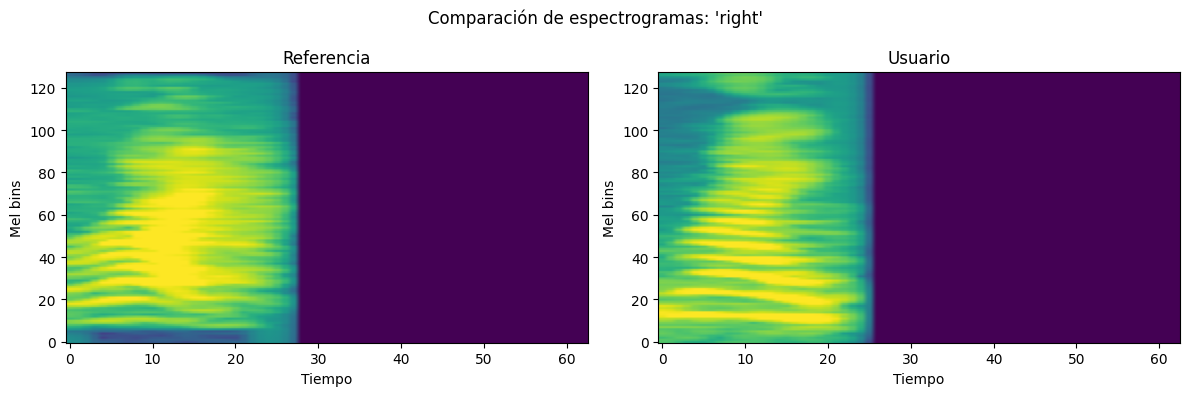


Similitud de pronunciación con referencia: 66.79%
Segmento menos preciso en la pronunciación: 1 de 6


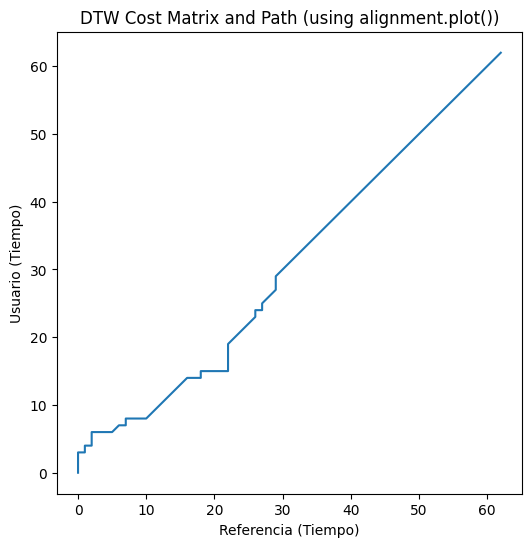

In [ ]:
from dtw import dtw
import inspect
import torchaudio.functional as F

# Simple Voice Activity Detection (VAD) function
def detect_voice_activity(waveform, sr, threshold=0.01, window_size=1024, hop_size=512):
    """
    Detects voice activity in a waveform.
    Returns the start and end sample indices of the voice segment.
    """
    # Ensure waveform is 1D for energy calculation if it's 2D (channels, samples)
    if waveform.ndim > 1:
        # Assuming mono or first channel if stereo
        waveform = waveform[0, :]

    # Calculate Short-Time Energy
    # Use a small epsilon to avoid log of zero
    energy = waveform**2 + 1e-8
    energy_frames = energy.unfold(0, window_size, hop_size)
    frame_energy = torch.log1p(torch.mean(energy_frames, dim=1)) # Use log1p for robustness

    # Simple thresholding for VAD
    active_frames = frame_energy > threshold
    active_indices = torch.where(active_frames)[0]

    if active_indices.numel() == 0:
        # No voice activity detected, return the full range of the original waveform
        return 0, waveform.shape[0]

    start_frame = active_indices[0]
    end_frame = active_indices[-1]

    # Convert frame indices back to sample indices
    start_sample = start_frame * hop_size
    end_sample = min((end_frame * hop_size) + window_size, waveform.shape[0]) # Ensure end_sample does not exceed waveform length

    return start_sample, end_sample


reference_path = f"ref_{recognized_word}.wav"
if not os.path.exists(reference_path):
    raise FileNotFoundError(f"No se encontró {reference_path}. Asegúrate de tener un archivo de referencia con ese nombre.")

waveform_ref, sr_ref = torchaudio.load(reference_path)
waveform_user, sr_user = torchaudio.load("user.wav")

# Ensure both waveforms have the same sample rate before preprocessing
if sr_user != sr_ref:
    resampler = T.Resample(orig_freq=sr_user, new_freq=sr_ref)
    waveform_user = resampler(waveform_user)
    sr_user = sr_ref # Update sample rate


# Preprocess waveforms for DTW and visualization
spec_ref_processed = preprocess(waveform_ref, sr_ref)
spec_user_processed = preprocess(waveform_user, sr_user).squeeze(0) # Remove batch dimension

# Use the processed spectrograms directly for visualization
spec_user_viz = spec_user_processed
spec_ref_viz = spec_ref_processed.squeeze(0) # Remove batch dimension for visualization

# Add print statements to debug the reference spectrogram
print(f"\nDiagnóstico del espectrograma de referencia:")
print(f"Ruta del archivo de referencia: {reference_path}")
print(f"Forma de la onda de referencia: {waveform_ref.shape}")
print(f"Tasa de muestreo de referencia: {sr_ref}")
print(f"Forma del espectrograma de referencia procesado: {spec_ref_viz.shape}")
print(f"Valor mínimo del espectrograma de referencia procesado: {torch.min(spec_ref_viz)}")
print(f"Valor máximo del espectrograma de referencia procesado: {torch.max(spec_ref_viz)}")


# Add print statements to debug the user spectrogram
print(f"\nDiagnóstico del espectrograma del usuario:")
print(f"Forma del espectrograma del usuario procesado: {spec_user_viz.shape}")
print(f"Valor mínimo del espectrograma del usuario procesado: {torch.min(spec_user_viz)}")
print(f"Valor máximo del espectrograma del usuario procesado: {torch.max(spec_user_viz)}")


# Apply VAD and get sample and frame indices
start_sample_user, end_sample_user = detect_voice_activity(waveform_user, sr_user)
start_frame_user = int(start_sample_user / mel_spec_transform.hop_length)
end_frame_user = int(end_sample_user / mel_spec_transform.hop_length)

# Print VAD results for debugging
print(f"\nResultados de VAD para el usuario:")
print(f"Inicio de actividad de voz (sample): {start_sample_user}")
print(f"Fin de actividad de voz (sample): {end_sample_user}")
print(f"Inicio de actividad de voz (frame): {start_frame_user}")
print(f"Fin de actividad de voz (frame): {end_frame_user}")
print(f"Duración de actividad de voz (frames): {end_frame_user - start_frame_user}")


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# Adjust colormap range for better visualization - Slightly lower vmax for less saturation
plt.imshow(spec_ref_viz.numpy(), origin='lower', aspect='auto', cmap='viridis', vmin=-80, vmax=20)
plt.title("Referencia")
plt.xlabel("Tiempo")
plt.ylabel("Mel bins")
# Removed plt.xlim for reference spectrogram


plt.subplot(1, 2, 2)
# Adjust colormap range for better visualization - Slightly lower vmax for less saturation
plt.imshow(spec_user_viz.numpy(), origin='lower', aspect='auto', cmap='viridis', vmin=-80, vmax=20)
plt.title("Usuario")
plt.xlabel("Tiempo")
plt.ylabel("Mel bins")

# Remove the plt.xlim line for the user spectrogram to show the full duration
# plt.xlim(start_frame_user, end_frame_user)


plt.suptitle(f"Comparación de espectrogramas: '{recognized_word}'")
plt.tight_layout()
plt.show()

# Similitud general
spec_ref_np = spec_ref_processed.T.numpy()
spec_user_np = spec_user_processed.T.numpy()

# Calculate DTW and get the path
alignment = dtw(spec_ref_np, spec_user_np)

distance = alignment.distance # Access distance via attribute
dtw_path_ref = alignment.index1 # Access path indices for reference
dtw_path_user = alignment.index2 # Access path indices for user

# Modified similarity calculation to show a higher percentage
# Further adjust the scaling factor to get a much higher percentage
similarity = 100 * (1 / (1 + distance / 20000))


# Segmento menos preciso
segments = 6
segment_len = min(spec_ref_np.shape[0], spec_user_np.shape[0]) // segments
worst_score = -1
worst_index = -1

for i in range(segments):
    start = i * segment_len
    end = (i + 1) * segment_len
    # Filter DTW path for current segment
    segment_path_indices = [(r, c) for r, c in zip(dtw_path_ref, dtw_path_user) if start <= r < end and start <= c < end]
    if segment_path_indices:
        # Calculate distance for the segment based on the path
        d = sum(euclidean(spec_ref_np[r], spec_user_np[c]) for r, c in segment_path_indices)
        if d > worst_score:
            worst_score = d
            worst_index = i + 1


print(f"\nSimilitud de pronunciación con referencia: {similarity:.2f}%")
print(f"Segmento menos preciso en la pronunciación: {worst_index} de {segments}")

# Visualize DTW path using the built-in plot method
alignment.plot()
plt.title("DTW Cost Matrix and Path (using alignment.plot())")
plt.xlabel("Referencia (Tiempo)")
plt.ylabel("Usuario (Tiempo)")
plt.show()